<a href="https://colab.research.google.com/github/shumshersubashgautam/Bird_Sound_Classify_Neural_Network/blob/main/Bird_Sound_Classification_BirdCLEF2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q kaggle

In [2]:
from google.colab import files

files.upload()

Saving kaggle (1).json to kaggle (1).json


{'kaggle (1).json': b'{"username":"shumshersubash2018","key":"f147ab838df934330c5631a31b26bec8"}'}

In [3]:
!mkdir ~/.kaggle

In [4]:
!cp kaggle.json ~/.kaggle/

In [5]:
 !chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle competitions download -c birdclef-2023

100% 4.91G/4.91G [03:56<00:00, 18.7MB/s]
100% 4.91G/4.91G [03:56<00:00, 22.3MB/s]


In [7]:
!mkdir bird

In [9]:
# tensorflow for tpu-vm
!pip install -q /lib/wheels/tensorflow-2.9.1-cp38-cp38-linux_x86_64.whl

# tensorflow utilities
!pip install -q tensorflow-addons==0.18.0
!pip install -q tensorflow-probability==0.17.0
!pip install -q tensorflow-io==0.26.0

# other utilies
!pip install -q opencv-python-headless librosa wandb scikit-learn

ERROR: tensorflow-2.9.1-cp38-cp38-linux_x86_64.whl is not a supported wheel on this platform.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 41.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.9/25.9 MB 35.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 56.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 22.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 754.9 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 KB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 6.6 MB/s eta 0:00:00


In [10]:
# efficientnet with filter stride reduction (FSR)
!pip install -qU git+https://github.com/awsaf49/efficientnet-spec

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 KB 1.9 MB/s eta 0:00:00


In [13]:
import os
import pandas as pd
pd.options.mode.chained_assignment = None # avoids assignment warning
import numpy as np
import random
from glob import glob
from tqdm import tqdm
tqdm.pandas()  # enable progress bars in pandas operations
import gc

import librosa
import sklearn
import json

# Import for visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import librosa.display as lid
import IPython.display as ipd

# Import tensorflow
import tensorflow as tf
# Set logging level to avoid unnecessary messages
tf.get_logger().setLevel('ERROR')
# Set autograph verbosity to avoid unnecessary messages
tf.autograph.set_verbosity(0)
# Enable xla for speed up
tf.config.optimizer.set_jit(True)

# Import required tensorflow modules
import tensorflow_io as tfio
import tensorflow_addons as tfa
import tensorflow_probability as tfp
import tensorflow.keras.backend as K

# Import KaggleDatasets for accessing Kaggle datasets
#from kaggle_datasets import KaggleDatasets

In [14]:
print('np:', np.__version__)
print('pd:', pd.__version__)
print('sklearn:', sklearn.__version__)
print('librosa:', librosa.__version__)
print('tf:', tf.__version__)
print('tfp:', tfp.__version__)
print('tfa:', tfa.__version__)
print('tfio:', tfio.__version__)

np: 1.22.4
pd: 1.4.4
sklearn: 1.2.2
librosa: 0.10.0.post2
tf: 2.12.0
tfp: 0.17.0
tfa: 0.18.0
tfio: 0.26.0


In [16]:
class CFG:
    # Debugging
    debug = False
    
    # Plot training history
    training_plot = True
    
    # Weights and Biases logging
    wandb = True
    competition   = 'birdclef-2023' 
    _wandb_kernel = 'awsaf49'
    
    # Experiment name and comment
    exp_name = 'baseline-v2'
    comment = 'EfficientNetB2|FSR|t=10s|128x384|up_thr=50|cv_filter'
    
    # Notebook link
    notebook_link = 'https://www.kaggle.com/awsaf49/birdclef23-effnet-fsr-cutmixup-train/edit'
    
    # Verbosity level
    verbose = 0
    
    # Device and random seed
    device = 'TPU-VM'
    seed = 42
    
    # Input image size and batch size
    img_size = [128, 384]
    batch_size = 32
    upsample_thr = 50 # min sample of each class (upsample)
    cv_filter = True # always keeps low sample data in train
    
    # Inference batch size, test time augmentation, and drop remainder
    infer_bs = 2
    tta = 1
    drop_remainder = True
    
    # Number of epochs, model name, and number of folds
    epochs = 25
    model_name = 'EfficientNetB2'
    fsr = True # reduce stride of stem block
    num_fold = 5
    
    # Selected folds for training and evaluation
    selected_folds = [0]

    # Pretraining, neck features, and final activation function
    pretrain = 'imagenet'
    neck_features = 0
    final_act = 'softmax'
    
    # Learning rate, optimizer, and scheduler
    lr = 1e-3
    scheduler = 'cos'
    optimizer = 'Adam' # AdamW, Adam
    
    # Loss function and label smoothing
    loss = 'CCE' # BCE, CCE
    label_smoothing = 0.05 # label smoothing
    
    # Audio duration, sample rate, and length
    duration = 10 # second
    sample_rate = 32000
    audio_len = duration*sample_rate
    
    # STFT parameters
    nfft = 2028
    window = 2048
    hop_length = audio_len // (img_size[1] - 1)
    fmin = 20
    fmax = 16000
    normalize = True
    
    # Data augmentation parameters
    augment=True
    
    # Spec augment
    spec_augment_prob = 0.80
    
    mixup_prob = 0.65
    mixup_alpha = 0.5
    
    cutmix_prob = 0.0
    cutmix_alpha = 0.5
    
    mask_prob = 0.65
    freq_mask = 20
    time_mask = 30


    # Audio Augmentation Settings
    audio_augment_prob = 0.5
    
    timeshift_prob = 0.0
    
    gn_prob = 0.35

    # Data Preprocessing Settings
    class_names = sorted(os.listdir('/content/bird/train_audio/'))
    num_classes = len(class_names)
    class_labels = list(range(num_classes))
    label2name = dict(zip(class_labels, class_names))
    name2label = {v:k for k,v in label2name.items()}

    # Training Settings
    target_col = ['target']
    tab_cols = ['filename']
    monitor = 'auc'

In [17]:
def seeding(SEED):
    np.random.seed(SEED)
    random.seed(SEED)
    os.environ['PYTHONHASHSEED'] = str(SEED)
#     os.environ['TF_CUDNN_DETERMINISTIC'] = str(SEED)
    tf.random.set_seed(SEED)
    print('seeding done!!!')
seeding(CFG.seed)

seeding done!!!


In [18]:
# Import wandb library for logging and tracking experiments
import wandb

# Try to get the API key from Kaggle secrets
try:
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    api_key = user_secrets.get_secret("WANDB")
    # Login to wandb with the API key
    wandb.login(key=api_key)
    # Set anonymous mode to None
    anonymous = None
except:
    # If Kaggle secrets are not available, set anonymous mode to 'must'
    anonymous = 'must'
    # Login to wandb anonymously and relogin if needed
    wandb.login(anonymous=anonymous, relogin=True)

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [19]:
def get_device():
    "Detect and intializes GPU/TPU automatically"
    # Check TPU category
    tpu = 'local' if CFG.device=='TPU-VM' else None
    try:
        # Connect to TPU
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect(tpu=tpu) 
        # Set TPU strategy
        strategy = tf.distribute.TPUStrategy(tpu)
        print(f'> Running on {CFG.device} ', tpu.master(), end=' | ')
        print('Num of TPUs: ', strategy.num_replicas_in_sync)
        device=CFG.device
    except:
        # If TPU is not available, detect GPUs
        gpus = tf.config.list_logical_devices('GPU')
        ngpu = len(gpus)
         # Check number of GPUs
        if ngpu:
            # Set GPU strategy
            strategy = tf.distribute.MirroredStrategy(gpus) # single-GPU or multi-GPU
            # Print GPU details
            print("> Running on GPU", end=' | ')
            print("Num of GPUs: ", ngpu)
            device='GPU'
        else:
            # If no GPUs are available, use CPU
            print("> Running on CPU")
            strategy = tf.distribute.get_strategy()
            device='CPU'
    return strategy, device, tpu

In [20]:
# Initialize GPU/TPU/TPU-VM
strategy, CFG.device, tpu = get_device()
CFG.replicas = strategy.num_replicas_in_sync

> Running on CPU


In [21]:
BASE_PATH = '/content/bird'

if CFG.device=="TPU":
    from kaggle_datasets import KaggleDatasets
    GCS_PATH = KaggleDatasets().get_gcs_path(BASE_PATH.split('/')[-1])
else:
    GCS_PATH = BASE_PATH

In [22]:
df = pd.read_csv(f'{BASE_PATH}/train_metadata.csv')
df['filepath'] = GCS_PATH + '/train_audio/' + df.filename
df['target'] = df.primary_label.map(CFG.name2label)
df.head(2)

primary_label secondary_labels      type  latitude  longitude  \
0       abethr1               []  ['song']    4.3906    38.2788   
1       abethr1               []  ['call']   -2.9524    38.2921   

      scientific_name               common_name         author  \
0  Turdus tephronotus  African Bare-eyed Thrush  Rolf A. de By   
1  Turdus tephronotus  African Bare-eyed Thrush  James Bradley   

                                             license  rating  \
0  Creative Commons Attribution-NonCommercial-Sha...     4.0   
1  Creative Commons Attribution-NonCommercial-Sha...     3.5   

                                 url              filename  \
0  https://www.xeno-canto.org/128013  abethr1/XC128013.ogg   
1  https://www.xeno-canto.org/363501  abethr1/XC363501.ogg   

                                         filepath  target  
0  /content/bird/train_audio/abethr1/XC128013.ogg       0  
1  /content/bird/train_audio/abethr1/XC363501.ogg       0

In [23]:
df.describe()

latitude     longitude        rating        target
count  16714.000000  16714.000000  16941.000000  16941.000000
mean      12.599897     22.035690      3.727732    127.721091
std       29.208254     28.743382      1.101060     75.833061
min      -38.116900   -157.819400      0.000000      0.000000
25%       -6.256000      5.941125      3.000000     71.000000
50%        2.359500     26.750650      4.000000    113.000000
75%       42.787100     36.589850      4.500000    201.000000
max       71.976900    177.684900      5.000000    263.000000

In [24]:
df.tail()

primary_label secondary_labels  type  latitude  longitude  \
16936       yewgre1               []  ['']   -1.2502    29.7971   
16937       yewgre1               []  ['']   -1.2489    29.7923   
16938       yewgre1               []  ['']   -1.2433    29.7844   
16939       yewgre1               []  ['']    0.0452    36.3699   
16940       yewgre1               []  ['']   -0.3986    37.3087   

            scientific_name                common_name          author  \
16936  Eurillas latirostris  Yellow-whiskered Greenbul  András Schmidt   
16937  Eurillas latirostris  Yellow-whiskered Greenbul  András Schmidt   
16938  Eurillas latirostris  Yellow-whiskered Greenbul  András Schmidt   
16939  Eurillas latirostris  Yellow-whiskered Greenbul   Lars Lachmann   
16940  Eurillas latirostris  Yellow-whiskered Greenbul   Lars Lachmann   

                                                 license  rating  \
16936  Creative Commons Attribution-NonCommercial-Sha...     3.0   
16937  Creative Commons Attribution-NonCommercial-Sha...     4.0   
16938  Creative Commons Attribution-NonCommercial-Sha...     4.0   
16939  Creative Commons Attribution-NonCommercial-Sha...     4.0   
16940  Creative Commons Attribution-NonCommercial-Sha...     4.5   

                                 url              filename  \
16936  https://xeno-canto.org/703472  yewgre1/XC703472.ogg   
16937  https://xeno-canto.org/703485  yewgre1/XC703485.ogg   
16938  https://xeno-canto.org/704433  yewgre1/XC704433.ogg   
16939  https://xeno-canto.org/752974  yewgre1/XC752974.ogg   
16940  https://xeno-canto.org/753190  yewgre1/XC753190.ogg   

                                             filepath  target  
16936  /content/bird/train_audio/yewgre1/XC703472.ogg     263  
16937  /content/bird/train_audio/yewgre1/XC703485.ogg     263  
16938  /content/bird/train_audio/yewgre1/XC704433.ogg     263  
16939  /content/bird/train_audio/yewgre1/XC752974.ogg     263  
16940  /content/bird/train_audio/yewgre1/XC753190.ogg     263

In [25]:
df.hist

<bound method hist_frame of       primary_label secondary_labels              type  latitude  longitude  \
0           abethr1               []          ['song']    4.3906    38.2788   
1           abethr1               []          ['call']   -2.9524    38.2921   
2           abethr1               []          ['song']   -2.9524    38.2921   
3           abethr1               []          ['song']   -2.9524    38.2921   
4           abethr1               []  ['call', 'song']   -2.9524    38.2921   
...             ...              ...               ...       ...        ...   
16936       yewgre1               []              ['']   -1.2502    29.7971   
16937       yewgre1               []              ['']   -1.2489    29.7923   
16938       yewgre1               []              ['']   -1.2433    29.7844   
16939       yewgre1               []              ['']    0.0452    36.3699   
16940       yewgre1               []              ['']   -0.3986    37.3087   

            scientific_

In [26]:
tf.io.gfile.exists(df.filepath.iloc[0])

True

In [38]:
import cv2

def load_audio(filepath):
    audio, sr = librosa.load(filepath)
    return audio, sr

# def show_image(filename):
#     #img = cv2.imread(f'/kaggle/input/birdclef23-image-dataset/{filename}.jpg')
#     #img=img[...,::-1] # bgr => rgb
#     plt.figure(figsize=(6, 6))
#     plt.imshow(img)
#     plt.axis('OFF')
#     plt.show()
#     return img

def get_spectrogram(audio):
    spec = librosa.feature.melspectrogram(y=audio, sr=CFG.sample_rate, 
                                   n_mels=CFG.img_size[0],
                                   n_fft=CFG.nfft,
                                   hop_length=CFG.hop_length,
                                   fmax=CFG.fmax,
                                   fmin=CFG.fmin,
                                   )
    spec = librosa.power_to_db(spec, ref=np.max)
    return spec

def display_audio(row):
    # Caption for viz
    caption = f'Id: {row.filename} | Name: {row.common_name} | Sci.Name: {row.scientific_name} | Rating: {row.rating}'
    # Read audio file
    audio, sr = load_audio(row.filepath)
    # Keep fixed length audio
    audio = audio[:CFG.audio_len]
    # Spectrogram from audio
    spec = get_spectrogram(audio)
    # Display audio
    print("# Audio:")
    display(ipd.Audio(audio, rate=CFG.sample_rate))
    print("# Image:")
    #show_image(row.common_name)
    print('# Visualization:')
    fig, ax = plt.subplots(2, 1, figsize=(12, 2*3), sharex=True, tight_layout=True)
    fig.suptitle(caption)
    # Waveplot
    lid.waveshow(audio,
                 sr=CFG.sample_rate,
                 ax=ax[0])
    # Specplot
    lid.specshow(spec, 
                 sr = CFG.sample_rate, 
                 hop_length = CFG.hop_length,
                 n_fft=CFG.nfft,
                 fmin=CFG.fmin,
                 fmax=CFG.fmax,
                 x_axis = 'time', 
                 y_axis = 'mel',
                 cmap = 'coolwarm',
                 ax=ax[1])
    ax[0].set_xlabel('');
    fig.show()

In [28]:
stat = df.primary_label.value_counts().index.tolist()
class_names = stat[:3] + stat[-3:] # popular + not popular

# Category: barswa
# Num Samples: 500
# Audio:


# Image:
# Visualization:


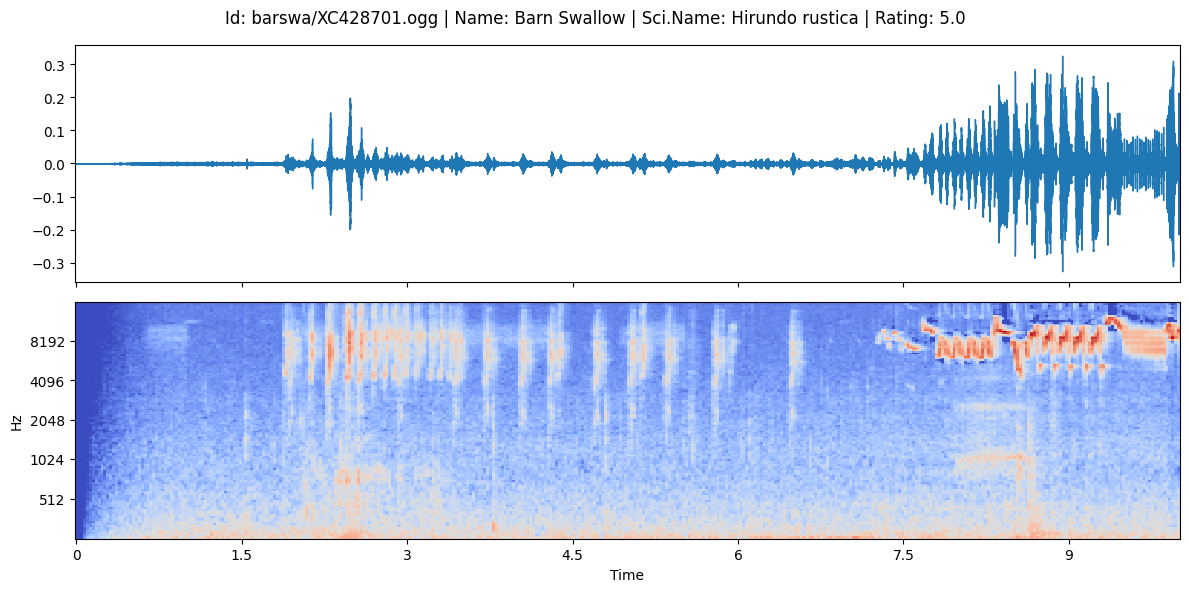

In [39]:
class_name = class_names[0]
print(f'# Category: {class_name}')
class_df = df.query("primary_label==@class_name")
print(f'# Num Samples: {len(class_df)}')
row = class_df.sample(1).squeeze()

# Display audio
display_audio(row)

# Category: wlwwar
# Num Samples: 500
# Audio:


# Image:
# Visualization:


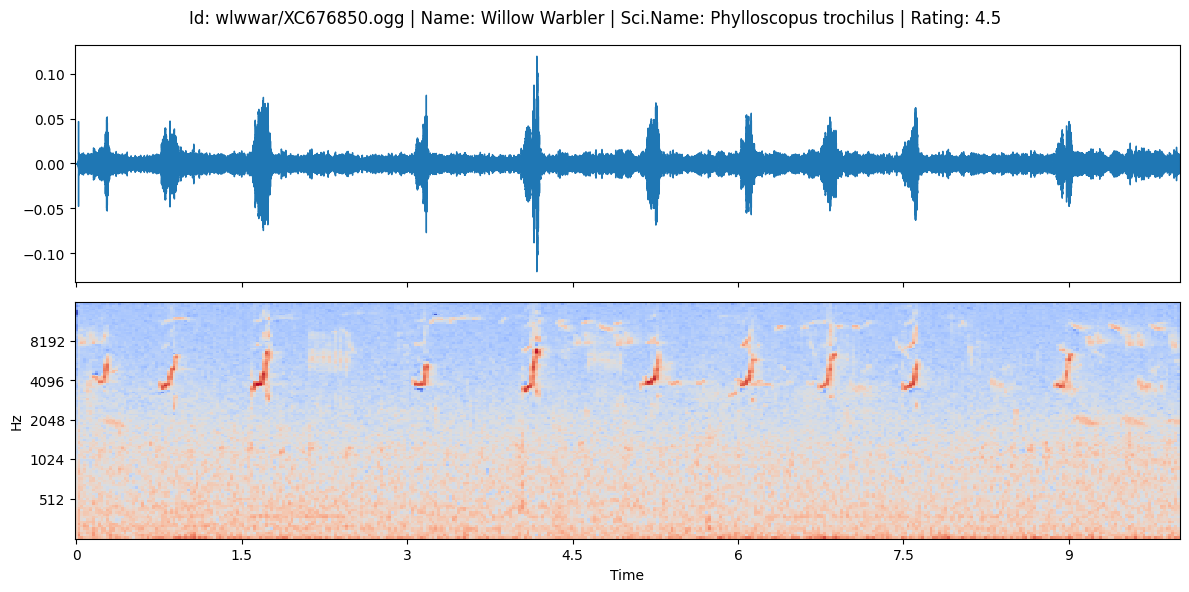

In [40]:
class_name = class_names[1]
print(f'# Category: {class_name}')
class_df = df.query("primary_label==@class_name")
print(f'# Num Samples: {len(class_df)}')
row = class_df.sample(1).squeeze()

# Display audio
display_audio(row)

# Category: thrnig1
# Num Samples: 500
# Audio:


# Image:
# Visualization:


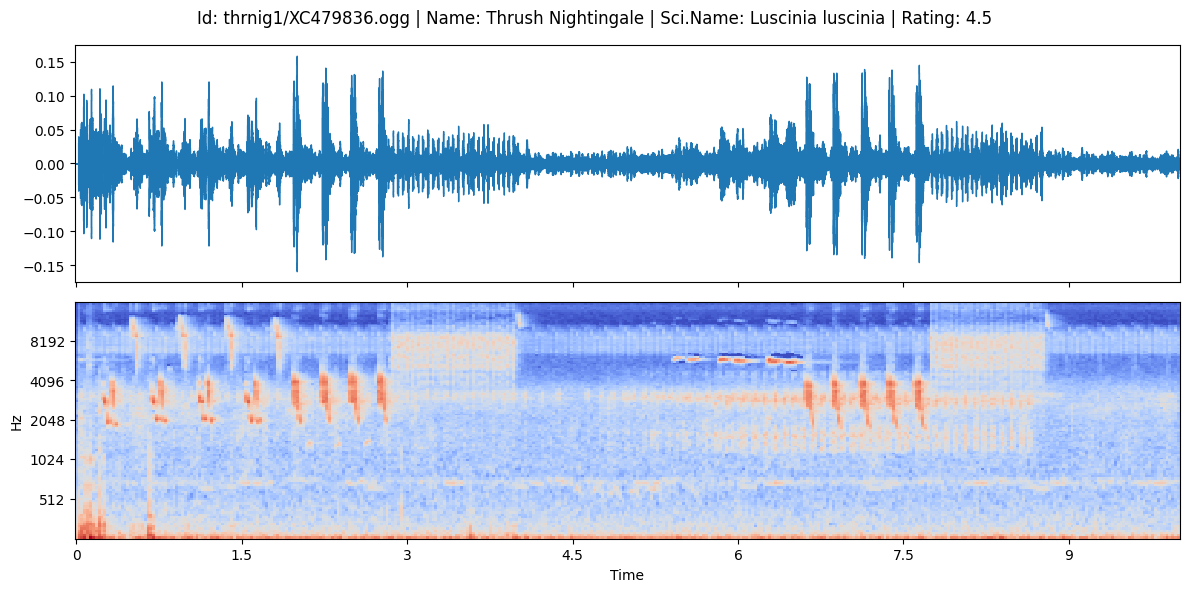

In [41]:
class_name = class_names[2]
print(f'# Category: {class_name}')
class_df = df.query("primary_label==@class_name")
print(f'# Num Samples: {len(class_df)}')
row = class_df.sample(1).squeeze()

# Display audio
display_audio(row)

# Category: whhsaw1
# Num Samples: 1
# Audio:


# Image:
# Visualization:


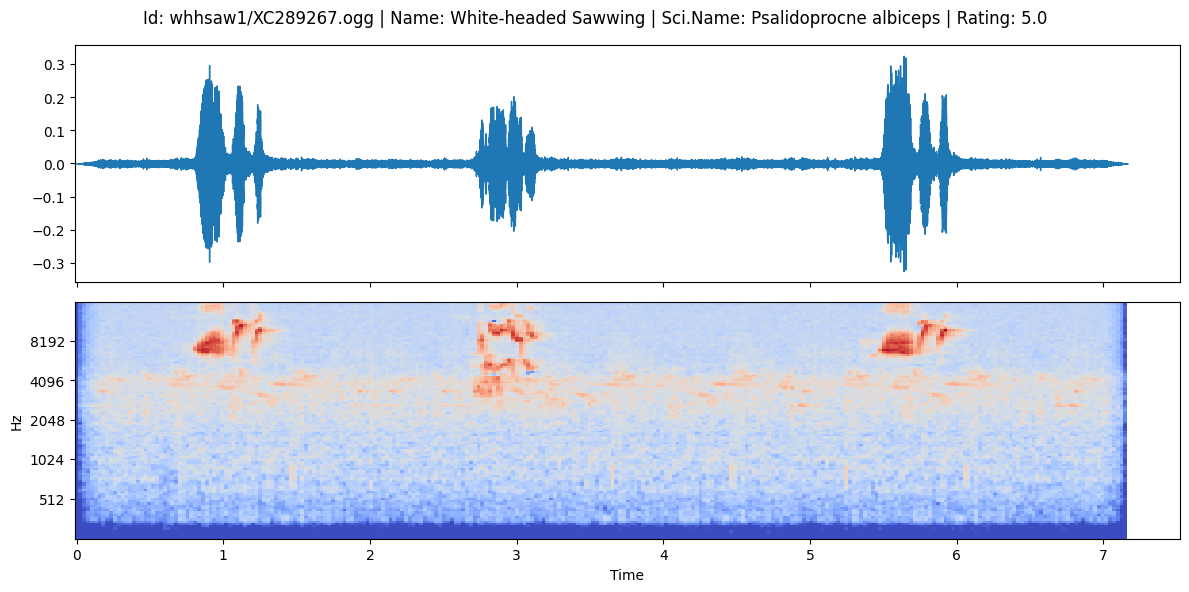

In [42]:
class_name = class_names[-3]
print(f'# Category: {class_name}')
class_df = df.query("primary_label==@class_name")
print(f'# Num Samples: {len(class_df)}')
row = class_df.sample(1).squeeze()

# Display audio
display_audio(row)

# Category: afpkin1
# Num Samples: 1
# Audio:


# Image:
# Visualization:


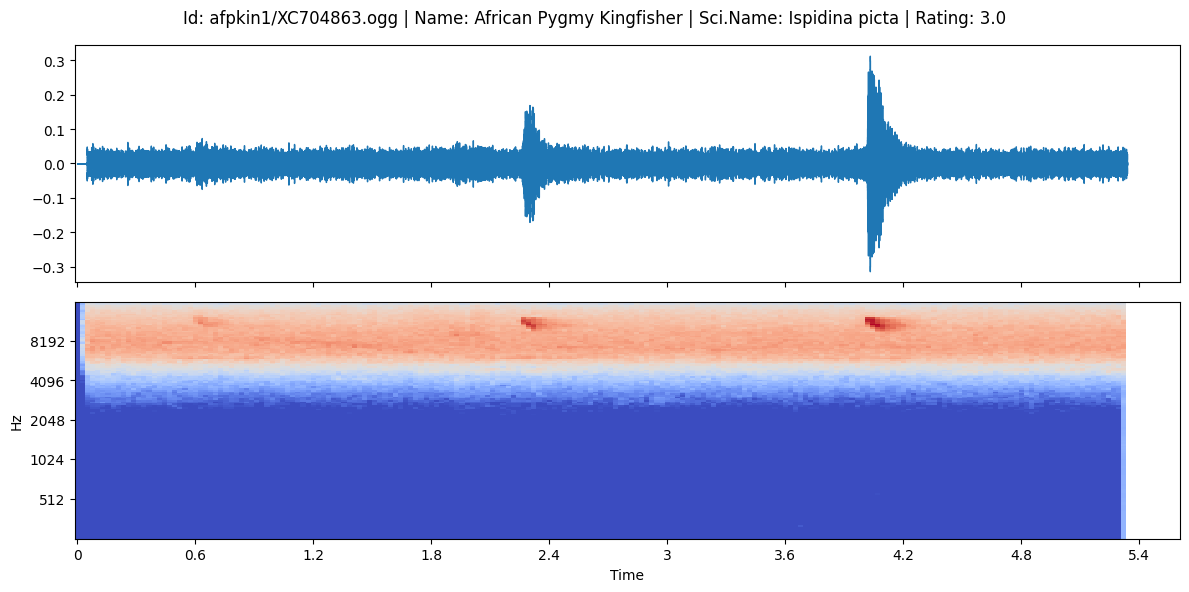

In [43]:
class_name = class_names[-2]
print(f'# Category: {class_name}')
class_df = df.query("primary_label==@class_name")
print(f'# Num Samples: {len(class_df)}')
row = class_df.sample(1).squeeze()

# Display audio
display_audio(row)

# Category: crefra2
# Num Samples: 1
# Audio:


# Image:
# Visualization:


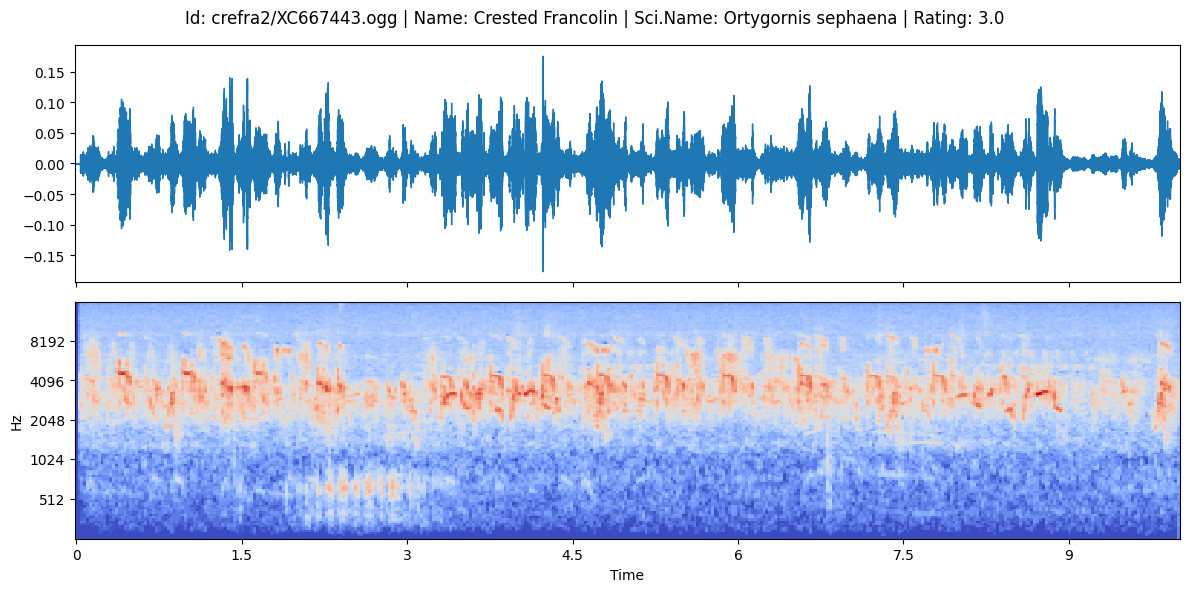

In [44]:
class_name = class_names[-1]
print(f'# Category: {class_name}')
class_df = df.query("primary_label==@class_name")
print(f'# Num Samples: {len(class_df)}')
row = class_df.sample(1).squeeze()

# Display audio
display_audio(row)

In [45]:
# Import required packages
from sklearn.model_selection import StratifiedKFold

# Initialize the StratifiedKFold object with 5 splits and shuffle the data
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=CFG.seed)

# Reset the index of the dataframe
df = df.reset_index(drop=True)

# Create a new column in the dataframe to store the fold number for each row
df["fold"] = -1

# Iterate over the folds and assign the corresponding fold number to each row in the dataframe
for fold, (train_idx, val_idx) in enumerate(skf.split(df, df['primary_label'])):
    df.loc[val_idx, 'fold'] = fold

/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


In [46]:
df.groupby(['fold','primary_label']).size()

fold  primary_label
0     abethr1           3
      abhori1          26
      abythr1           5
      afbfly1           4
      afdfly1           6
                       ..
4     yertin1          27
      yesbar1           6
      yespet1           3
      yetgre1           5
      yewgre1          22
Length: 1271, dtype: int64

In [47]:
def filter_data(df, thr=5):
    # Count the number of samples for each class
    counts = df.primary_label.value_counts()

    # Condition that selects classes with less than `thr` samples
    cond = df.primary_label.isin(counts[counts<thr].index.tolist())

    # Add a new column to select samples for cross validation
    df['cv'] = True

    # Set cv = False for those class where there is samples less than thr
    df.loc[cond, 'cv'] = False

    # Return the filtered dataframe
    return df
    
def upsample_data(df, thr=20):
    # get the class distribution
    class_dist = df['primary_label'].value_counts()

    # identify the classes that have less than the threshold number of samples
    down_classes = class_dist[class_dist < thr].index.tolist()

    # create an empty list to store the upsampled dataframes
    up_dfs = []

    # loop through the undersampled classes and upsample them
    for c in down_classes:
        # get the dataframe for the current class
        class_df = df.query("primary_label==@c")
        # find number of samples to add
        num_up = thr - class_df.shape[0]
        # upsample the dataframe
        class_df = class_df.sample(n=num_up, replace=True, random_state=CFG.seed)
        # append the upsampled dataframe to the list
        up_dfs.append(class_df)

    # concatenate the upsampled dataframes and the original dataframe
    up_df = pd.concat([df] + up_dfs, axis=0, ignore_index=True)
    
    return up_df

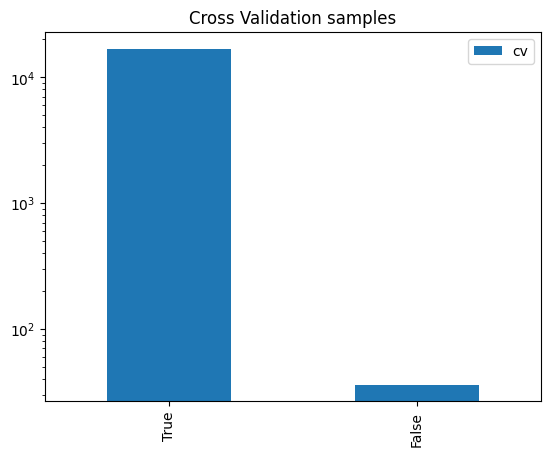

In [48]:
# Filter data
f_df = filter_data(df, thr=5)
f_df.cv.value_counts().plot.bar(legend=True)
plt.yscale("log")
plt.title("Cross Validation samples")
plt.show()

Before Upsample Size: 16941
After Upsample Size: 22208


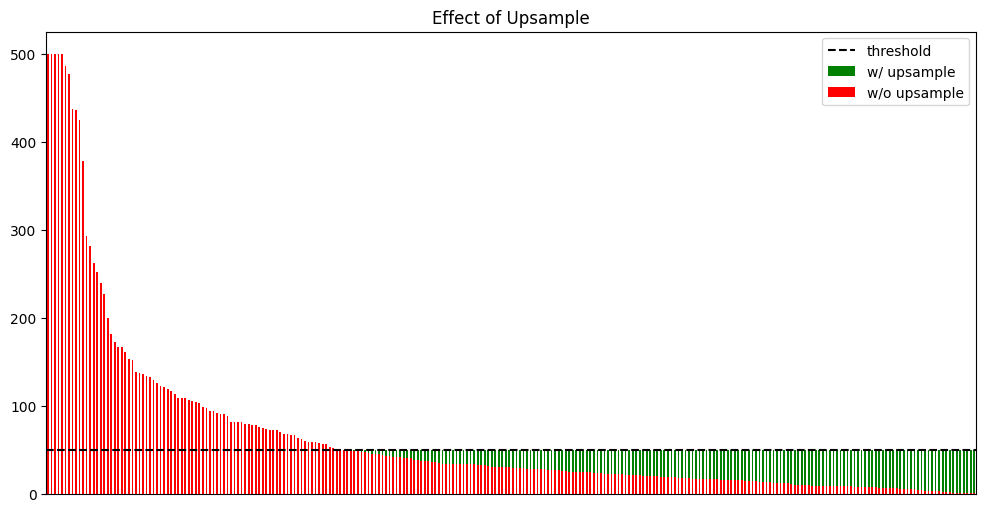

In [49]:
# Upsample data
up_df = upsample_data(df, thr=50)
print(f'Before Upsample Size: {len(df)}')
print(f'After Upsample Size: {len(up_df)}')

# Show effect of upsample
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
up_df.primary_label.value_counts()[:].plot.bar(ax=ax, color='green', label='w/ upsample')
df.primary_label.value_counts()[:].plot.bar(ax=ax, color='red', label='w/o upsample')
plt.xticks([])
plt.axhline(y=50, color='k', linestyle='--', label='threshold')
plt.legend()
plt.title("Effect of Upsample")
plt.show()

In [50]:
# Compute Spectrogram from audio
@tf.function
def Audio2Spec(audio, spec_shape=[128, 384], sr=32000, nfft=2048, window=2048, fmin=500, fmax=14000):
    """
    Computes a Mel-scaled spectrogram from audio using TensorFlow and TensorFlow-IO.
    """
    # Get the desired height and width of the spectrogram
    spec_height = spec_shape[0]
    spec_width = spec_shape[1]
    
    # Get the length of the audio and calculate the hop length for the STFT
    audio_len = tf.shape(audio)[0]
    hop_length = tf.cast((audio_len // (spec_width - 1)), tf.int32) # sample rate * duration / spec width - 1 == 627
    
    # Compute the spectrogram and the Mel-scaled spectrogram using TensorFlow-IO
    spec = tfio.audio.spectrogram(audio, nfft=nfft, window=window, stride=hop_length)
    mel_spec = tfio.audio.melscale(spec, rate=sr, mels=spec_height, fmin=fmin, fmax=fmax)
    
    # Convert the Mel-scaled spectrogram to decibels and transpose it to keep it (mel, time)
    db_mel_spec = tfio.audio.dbscale(mel_spec, top_db=80)
    db_mel_spec = tf.transpose(db_mel_spec, perm=[1, 0])
    
    # If the spectrogram is larger than the desired shape, crop it
    if tf.shape(db_mel_spec)[1] > spec_width:
        db_mel_spec = db_mel_spec[:, :spec_width]
    
    # Reshape the spectrogram to the desired shape and return it
    db_mel_spec = tf.reshape(db_mel_spec, spec_shape)
    return db_mel_spec


In [51]:
# Decodes Audio
def audio_decoder(with_labels=True, dim=CFG.audio_len, CFG=CFG):
    def get_audio(filepath):
        file_bytes = tf.io.read_file(filepath)
        audio = tfio.audio.decode_vorbis(file_bytes) # decode .ogg file for .wave replace `decode_wav`
        audio = tf.cast(audio, tf.float32)
        audio = tf.squeeze(audio, axis=-1)
        if CFG.normalize:
            audio = Normalize(audio)
        return audio

    def get_target(target):          
        target = tf.reshape(target, [1])
        target = tf.cast(tf.one_hot(target, len(CFG.class_labels)), tf.float32) 
        target = tf.reshape(target, [len(CFG.class_labels)])
        return target

    def decode(path):
        audio = get_audio(path)
        audio = CropOrPad(audio, dim) # crop or pad audio to keep a fixed length
        audio = tf.reshape(audio, [dim])
        return audio
    
    def decode_with_labels(path, label):
        label = get_target(label)
        return decode(path), label
    
    return decode_with_labels if with_labels else decode

# Decodes Spectrogram
def spec_decoder(with_labels=True, dim=CFG.img_size, CFG=CFG):
    def decode(audio):
        # Compute Spectrogram
        spec = Audio2Spec(audio, spec_shape=dim, sr=CFG.sample_rate, 
                          nfft=CFG.nfft, window=CFG.window, fmin=CFG.fmin,fmax=CFG.fmax)
        # Spectrogram (H, W) to Image (H, W, C)
        spec = Spec2Img(spec, num_channels=3) 
        spec = tf.reshape(spec, [*dim, 3])
        return spec
    
    def decode_with_labels(path, label):
        return decode(path), label
    
    return decode_with_labels if with_labels else decode

In [52]:
# Applies augmentation to audio
def audio_augmenter(with_labels=True, dim=CFG.audio_len, CFG=CFG):
    def augment(audio, dim=dim):
        if random_float() <= CFG.audio_augment_prob:
            audio = AudioAug(audio)
        audio = tf.reshape(audio, [dim])
        return audio
    
    def augment_with_labels(audio, label):    
        return augment(audio), label
    
    return augment_with_labels if with_labels else augment

# Applies augentation to spectrogram
def spec_augmenter(with_labels=True, dim=CFG.img_size, CFG=CFG):
    def augment(spec, dim=dim): 
        if random_float() <= CFG.spec_augment_prob:
            spec = SpecAug(spec)
        spec = tf.reshape(spec, [*dim, 3])
        return spec
    
    def augment_with_labels(spec, label):    
        return augment(spec), label
    
    return augment_with_labels if with_labels else augment

In [53]:
def build_dataset(paths, labels=None, batch_size=32, target_size=[128, 256], 
                  audio_decode_fn=None, audio_augment_fn=None, 
                  spec_decode_fn=None, spec_augment_fn=None,
                  cache=True, cache_dir="",drop_remainder=False,
                  augment=True, repeat=True, shuffle=1024):
    """
    Creates a TensorFlow dataset from the given paths and labels.
    
    Args:
        paths (list): A list of file paths to the audio files.
        labels (list): A list of corresponding labels for the audio files.
        batch_size (int): Batch size for the created dataset.
        target_size (list): A list of target image size for the spectrograms.
        audio_decode_fn (function): A function to decode the audio file.
        audio_augment_fn (function): A function to augment the audio file.
        spec_decode_fn (function): A function to decode the spectrogram.
        spec_augment_fn (function): A function to augment the spectrogram.
        cache (bool): Whether to cache the dataset or not.
        cache_dir (str): Directory path to cache the dataset.
        drop_remainder (bool): Whether to drop the last batch if it is smaller than batch_size.
        augment (bool): Whether to augment the dataset or not.
        repeat (bool): Whether to repeat the dataset or not.
        shuffle (int): Number of elements from the dataset to buffer for shuffling.
        
    Returns:
        ds (tf.data.Dataset): A TensorFlow dataset.
    """
    # Create cache directory if cache is enabled
    if cache_dir != "" and cache is True:
        os.makedirs(cache_dir, exist_ok=True)
    # Set default audio decode function if not provided
    if audio_decode_fn is None:
        audio_decode_fn = audio_decoder(
            labels is not None, dim=CFG.audio_len, CFG=CFG)
    # Set default audio augmentation function if not provided
    if audio_augment_fn is None:
        audio_augment_fn = audio_augmenter(
            labels is not None, dim=CFG.audio_len, CFG=CFG)
    # Set default spectrogram decode function if not provided
    if spec_decode_fn is None:
        spec_decode_fn = spec_decoder(
            labels is not None, dim=CFG.img_size, CFG=CFG)
    # Set default spectrogram augmentation function if not provided
    if spec_augment_fn is None:
        spec_augment_fn = spec_augmenter(
            labels is not None, dim=CFG.img_size, CFG=CFG)
    # Set TensorFlow AUTOTUNE option
    AUTO = tf.data.experimental.AUTOTUNE
    
    # Create slices based on whether labels are provided
    slices = paths if labels is None else (paths, labels)
    # Create TensorFlow dataset from slices
    ds = tf.data.Dataset.from_tensor_slices(slices)
    # Map audio decode function to dataset
    ds = ds.map(audio_decode_fn, num_parallel_calls=AUTO)
    # Cache dataset in memory if cache is enabled
    ds = ds.cache(cache_dir) if cache else ds
    # Repeat dataset indefinitely if repeat is enabled
    ds = ds.repeat() if repeat else ds
    # Create TensorFlow dataset options
    opt = tf.data.Options()
    # Shuffle dataset if shuffle is enabled
    if shuffle: 
        ds = ds.shuffle(shuffle, seed=CFG.seed)
        opt.experimental_deterministic = False
    if CFG.device=='GPU':
        # If the device is a GPU, turn off auto-sharding to avoid performance issues
        opt.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.OFF
    # Set the options for the dataset
    ds = ds.with_options(opt)
    # Apply audio augmentation to the dataset if augment is True
    ds = ds.map(audio_augment_fn, num_parallel_calls=AUTO) if augment else ds
    # Decode the spectrograms for the dataset
    ds = ds.map(spec_decode_fn, num_parallel_calls=AUTO)
    # Apply spectrogram augmentation to the dataset if augment is True
    ds = ds.map(spec_augment_fn, num_parallel_calls=AUTO) if augment else ds
    # Batch the dataset with the specified batch size
    ds = ds.batch(batch_size, drop_remainder=drop_remainder)
    # MixUp: apply MixUp regularization to the dataset if specified
    if CFG.mixup_prob and augment and labels is not None:
        ds = ds.map(MixUp(alpha=CFG.mixup_alpha,prob=CFG.mixup_prob),num_parallel_calls=AUTO)
    # CutMix: apply CutMix regularization to the dataset if specified
    if CFG.cutmix_prob and augment and labels is not None:
        ds = ds.map(CutMix(alpha=CFG.cutmix_alpha,prob=CFG.cutmix_prob),num_parallel_calls=AUTO)
    # Prefetch the next batch of data to improve performance
    ds = ds.prefetch(AUTO)
    return ds

In [54]:
def plot_batch(batch, row=3, col=3):
    """Plot one batch data"""
    if isinstance(batch, tuple) or isinstance(batch, list):
        imgs, tars = batch
    else:
        imgs = batch
        tars = None
    plt.figure(figsize=(col*5, row*3))
    for idx in range(row*col):
        ax = plt.subplot(row, col, idx+1)
        lid.specshow(imgs[idx][...,0].numpy(), 
                     sr = CFG.sample_rate, 
                     hop_length = CFG.hop_length,
                     fmin=CFG.fmin,
                     fmax=CFG.fmax,
                     x_axis = 'time', 
                     y_axis = 'mel',
                     cmap = 'coolwarm')
        if tars is not None:
            label = tars[idx].numpy().argmax()
            name = CFG.label2name[label]
            plt.title(name)
    plt.tight_layout()
    plt.show()
    
    
def plot_history(history):
    """Plot trainign history, credit: @cdeotte"""
    epochs = len(history.history['auc'])
    plt.figure(figsize=(15,5))
    plt.plot(np.arange(epochs),history.history['auc'],'-o',label='Train AUC',color='#ff7f0e')
    plt.plot(np.arange(epochs),history.history['val_auc'],'-o',label='Val AUC',color='#1f77b4')
    x = np.argmax( history.history['val_auc'] ); y = np.max( history.history['val_auc'] )
    xdist = plt.xlim()[1] - plt.xlim()[0]; ydist = plt.ylim()[1] - plt.ylim()[0]
    plt.scatter(x,y,s=200,color='#1f77b4'); plt.text(x-0.03*xdist,y-0.13*ydist,'max auc\n%.2f'%y,size=14)
    plt.ylabel('AUC (PR)',size=14); plt.xlabel('Epoch',size=14)
    plt.legend(loc=2)
    plt2 = plt.gca().twinx()
    plt2.plot(np.arange(epochs),history.history['loss'],'-o',label='Train Loss',color='#2ca02c')
    plt2.plot(np.arange(epochs),history.history['val_loss'],'-o',label='Val Loss',color='#d62728')
    x = np.argmin( history.history['val_loss'] ); y = np.min( history.history['val_loss'] )
    ydist = plt.ylim()[1] - plt.ylim()[0]
    plt.scatter(x,y,s=200,color='#d62728'); plt.text(x-0.03*xdist,y+0.05*ydist,'min loss',size=14)
    plt.ylabel('Loss',size=14)
    plt.title('Fold %i - Training Plot'%(fold+1),size=18)
    plt.legend(loc=3)
    plt.show()  

In [55]:
ds = build_dataset(df.filepath.tolist(), df.target.tolist(), augment=False, cache=False)
ds = ds.take(100)
imgs, labels = next(iter(ds))
plot_batch((imgs, labels))

NotImplementedError: ignored

In [56]:
ds = build_dataset(df.filepath.tolist(), df.target.tolist(), augment=True, cache=False)
ds = ds.take(100)
imgs, labels = next(iter(ds))
plot_batch((imgs, labels))

NotImplementedError: ignored

In [57]:
import sklearn.metrics

def get_metrics():
#     acc = tf.keras.metrics.BinaryAccuracy(name='acc')
    auc = tf.keras.metrics.AUC(curve='PR', name='auc', multi_label=False) # auc on prcision-recall curve
    acc = tf.keras.metrics.CategoricalAccuracy(name='acc')
    return [acc, auc]

def padded_cmap(y_true, y_pred, padding_factor=5):
    num_classes = y_true.shape[1]
    pad_rows = np.array([[1]*num_classes]*padding_factor)
    y_true = np.concatenate([y_true, pad_rows])
    y_pred = np.concatenate([y_pred, pad_rows])
    score = sklearn.metrics.average_precision_score(y_true, y_pred, average='macro',)
    return score

def get_loss():
    if CFG.loss=="CCE":
        loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=CFG.label_smoothing)
    elif CFG.loss=="BCE":
        loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=CFG.label_smoothing)
    else:
        raise ValueError("Loss not found")
    return loss
    
def get_optimizer():
    if CFG.optimizer == "Adam":
        opt = tf.keras.optimizers.Adam(learning_rate=CFG.lr)
    else:
        raise ValueError("Optmizer not found")
    return opt

In [58]:
import efficientnet.tfkeras as efn

def build_model(CFG, compile_model=True):
    """
    Builds and returns a model based on the specified configuration.
    """
    # Set the image input shape
    DIM = (None, None)
    # Load the specified EfficientNet model
    base = getattr(efn, CFG.model_name)(input_shape=(*DIM, 3),
                                        include_top=False,
                                        weights=CFG.pretrain,
                                        fsr=CFG.fsr,
                                        )
    # Create an input layer for the model
    inp = tf.keras.layers.Input(shape=(*DIM, 3))
    # Pass the input through the base model
    out = base(inp)
    # Add a global average pooling layer
    out = tf.keras.layers.GlobalAveragePooling2D()(out)
    # Add an optional bottleneck layer
    if CFG.neck_features:
        out = tf.keras.layers.Dense(CFG.num_features, activation='selu')(out)
    # Add a final dense layer for classification
    out = tf.keras.layers.Dense(len(CFG.class_names), activation=CFG.final_act)(out)
    # Create the TensorFlow model with the input and output layers
    model = tf.keras.Model(inputs=inp, outputs=out)
    if compile_model:
        # Set the optimizer
        opt = get_optimizer()
        # Set the loss function
        loss = get_loss()
        # Set the evaluation metrics
        metrics = get_metrics()
        # Compile the model with the specified optimizer, loss function, and metrics
        model.compile(optimizer=opt,
                      loss=loss,
                      metrics=metrics)
    return model

In [59]:
model = build_model(CFG)
model.summary()

31936256/31936256 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 efficientnet-b2 (Functional  (None, None, None, 1408)  7768562  
 )                                                               
                                                                 
 global_average_pooling2d (G  (None, 1408)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 264)               371976    
                                                                 
Total params: 8,140,538
Trainable params: 8,072,970
Non-trainable params: 67,568
_______________________________________________

In [62]:
import math

def get_lr_callback(batch_size=8, mode='cos', epochs=CFG.epochs, plot=False):
    """
    Returns a learning rate scheduler callback for a given batch size, mode, and number of epochs.
    """
    # Define the learning rate schedule.
    lr_start   = 0.000005
    lr_max     = 0.00000140 * batch_size
    lr_min     = 0.000001
    lr_ramp_ep = 5
    lr_sus_ep  = 0
    lr_decay   = 0.8
   
    # Function to update the lr
    def lrfn(epoch):
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start

        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max

        elif CFG.scheduler == 'exp':
            lr = (lr_max - lr_min) * lr_decay**(epoch - \
                  lr_ramp_ep - lr_sus_ep) + lr_min

        elif CFG.scheduler == 'step':
            lr = lr_max * lr_decay**((epoch - lr_ramp_ep - lr_sus_ep) // 2)

        elif CFG.scheduler == 'cos':
            decay_total_epochs = epochs - lr_ramp_ep - lr_sus_ep + 3
            decay_epoch_index = epoch - lr_ramp_ep - lr_sus_ep
            phase = math.pi * decay_epoch_index / decay_total_epochs
            cosine_decay = 0.5 * (1 + math.cos(phase))
            lr = (lr_max - lr_min) * cosine_decay + lr_min
        return lr
    
    # Plot the lr curve
    if plot:
        plt.figure(figsize=(10,5))
        plt.plot(np.arange(epochs), [lrfn(epoch) for epoch in np.arange(epochs)], marker='o')
        plt.xlabel('epoch'); plt.ylabel('learnig rate')
        plt.title('Learning Rate Scheduler')
        plt.show()
        
    # Crate lr-callback to update lr during training
    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=False)
    return lr_callback

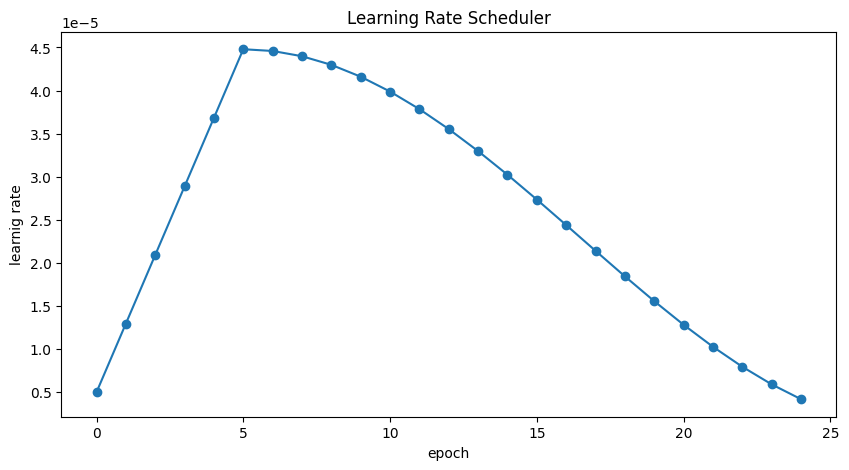

In [63]:
_=get_lr_callback(CFG.batch_size*CFG.replicas, plot=True)

In [ ]:
# import yaml

# def wandb_init(fold):
#     """
#     Initializes the W&B run by creating a config file and initializing a W&B run.
#     """
#     # Create a dictionary of configuration parameters
#     config = {k:v for k,v in dict(vars(CFG)).items() if '__' not in k}
#     config.update({"fold":int(fold)}) # int is to convert numpy.int -> int
#     # Dump the configuration dictionary to a YAML file
#     yaml.dump(config, open(f'/kaggle/working/config fold-{fold}.yaml', 'w'),)
#     # Load the configuration dictionary from the YAML file
#     config = yaml.load(open(f'/kaggle/working/config fold-{fold}.yaml', 'r'), Loader=yaml.FullLoader)
#     # Initialize a W&B run with the given configuration parameters
#     run = wandb.init(project="birdclef-2023-public",
#                      name=f"fold-{fold}|dim-{CFG.img_size[1]}x{CFG.img_size[0]}|model-{CFG.model_name}",
#                      config=config,
#                      group=CFG.comment,
#                      save_code=True,)
#     return run

    
# def log_wandb(valid_df):
#     """Log and save validation results with missclassified examples as audio in W&B"""
#     # Query only the rows with miss predictions
#     save_df = valid_df.query("miss==True")
#     # Map the predicted and target labels to their corresponding names
#     save_df.loc[:, 'pred_name'] = save_df.pred.map(CFG.label2name)
#     save_df.loc[:, 'target_name'] = save_df.target.map(CFG.label2name)
#     # Trim the dataframe for debugging purposes
#     if CFG.debug:
#         save_df = save_df.iloc[:CFG.replicas*CFG.batch_size*CFG.infer_bs]
#     # Get the columns to be included in the wandb table
#     noimg_cols = [*CFG.tab_cols, 'target', 'pred', 'target_name','pred_name']
#     # Retain only the necessary columns
#     save_df = save_df.loc[:, noimg_cols]

#     data = []
#     # Load audio files for each miss prediction
#     for idx, row in tqdm(save_df.iterrows(), total=len(save_df), desc='wandb ', position=0, leave=True):
#         filepath = '/kaggle/input/birdclef-2023/train_audio/'+row.filename
#         audio, sr = librosa.load(filepath, sr=None)
#         # Add the audio file to the data list along with the other relevant information
#         data+=[[*row.tolist(), wandb.Audio(audio, caption=row.filename, sample_rate=sr)]]
#     # Create a wandb table with the audio files and other relevant information
#     wandb_table = wandb.Table(data=data, columns=[*noimg_cols, 'audio'])
#     # Log the scores and wandb table to wandb
#     wandb.log({'best': scores,
#                'table': wandb_table,
#                })